C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


Loading embeddings from: ./embeddings/final_embeddings_molecules_20250308_221455.pkl
Loaded 41 embeddings
Reducing dimensionality with UMAP...
Rebuilding molecules from graph data...
Error finalizing molecule: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 304 in file Code\GraphMol\Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2024.09.3
	BOOST: 

Error finalizing molecule: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 304 in file Code\GraphMol\Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2024.09.3
	BOOST: 

Error finalizing molecule: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 304 in file Code\GraphMol\Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2024.09.3
	BOOST: 

Error finalizing molecule: Pre-condit

[22:23:38] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.cpp
Failed Expression: d_implicitValence > -1
****

[22:23:38] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.cpp
Failed Expression: d_implicitValence > -1
****

[22:23:38] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.cpp
Failed Expression: d_implicitValence > -1
****

[22:23:38] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.

Finding cluster representatives...
Creating advanced visualization...
Visualization saved to: ./visualizations/advanced_molecular_embedding.png
Creating additional visualizations with different properties...
Visualizing by logp...
Visualization saved to: ./visualizations/molecular_embedding_logp.png
Visualizing by tpsa...
Visualization saved to: ./visualizations/molecular_embedding_tpsa.png
Visualizing by num_rings...
Visualization saved to: ./visualizations/molecular_embedding_num_rings.png
Visualization complete!


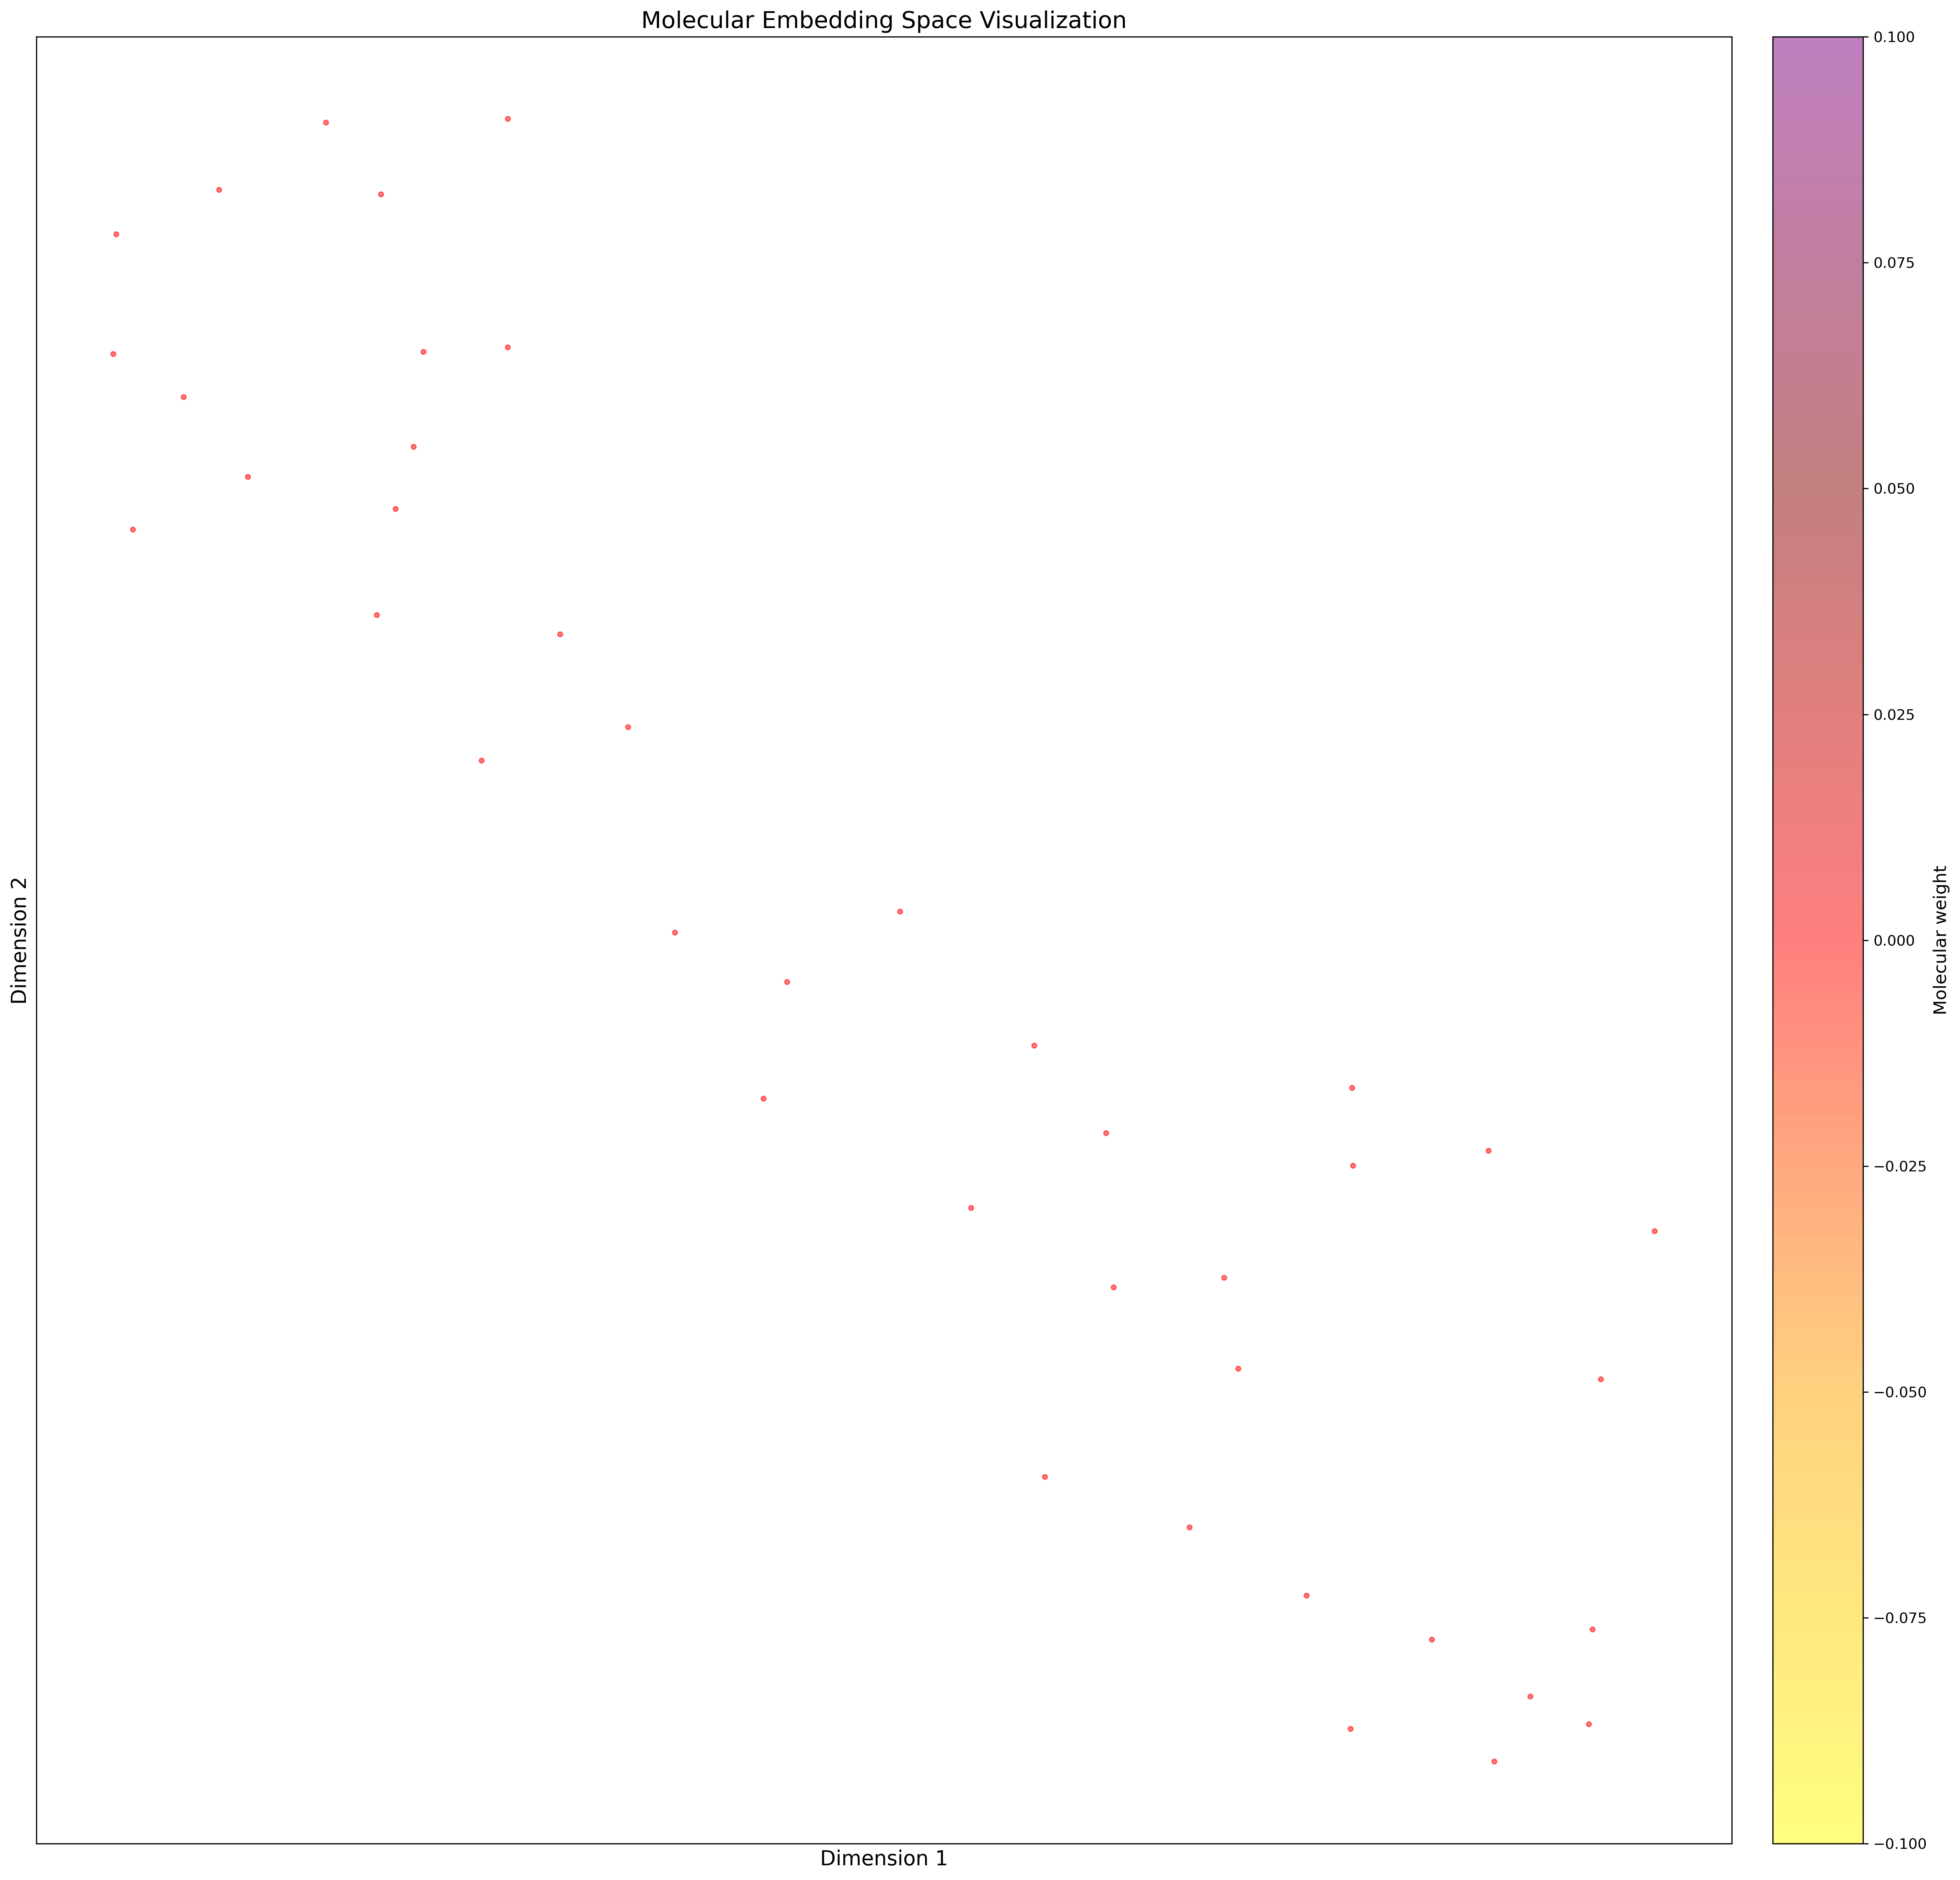

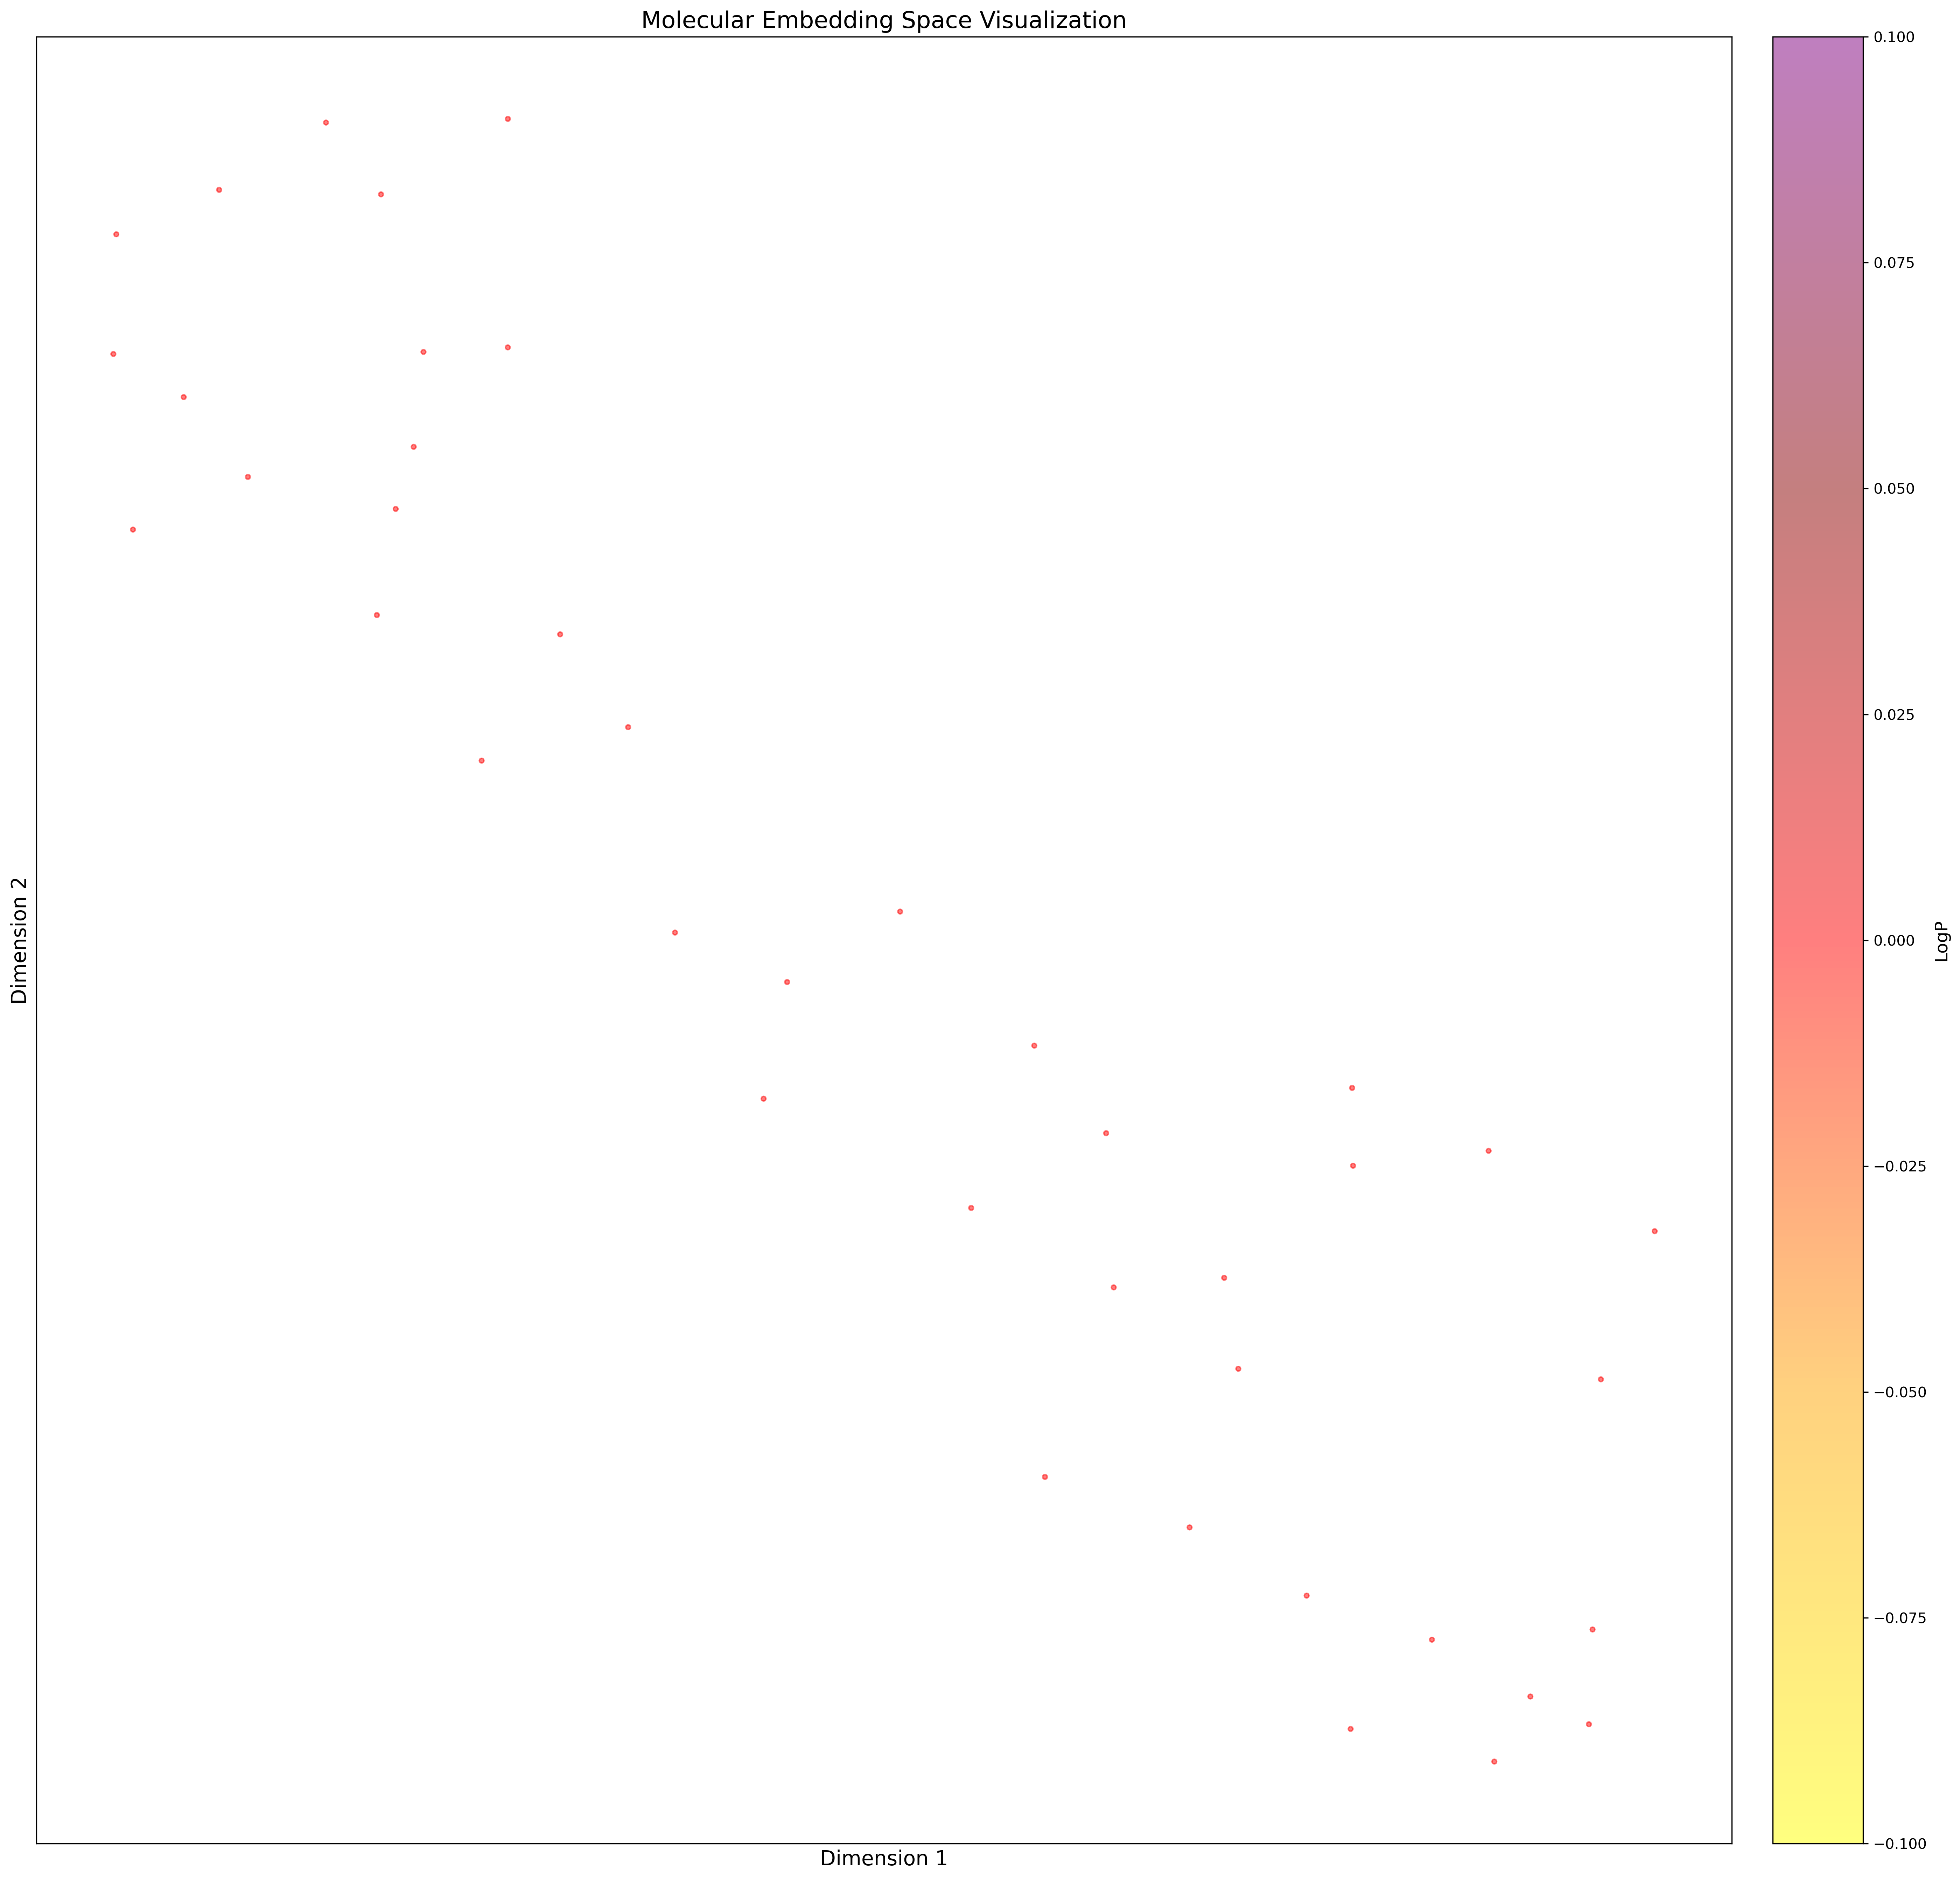

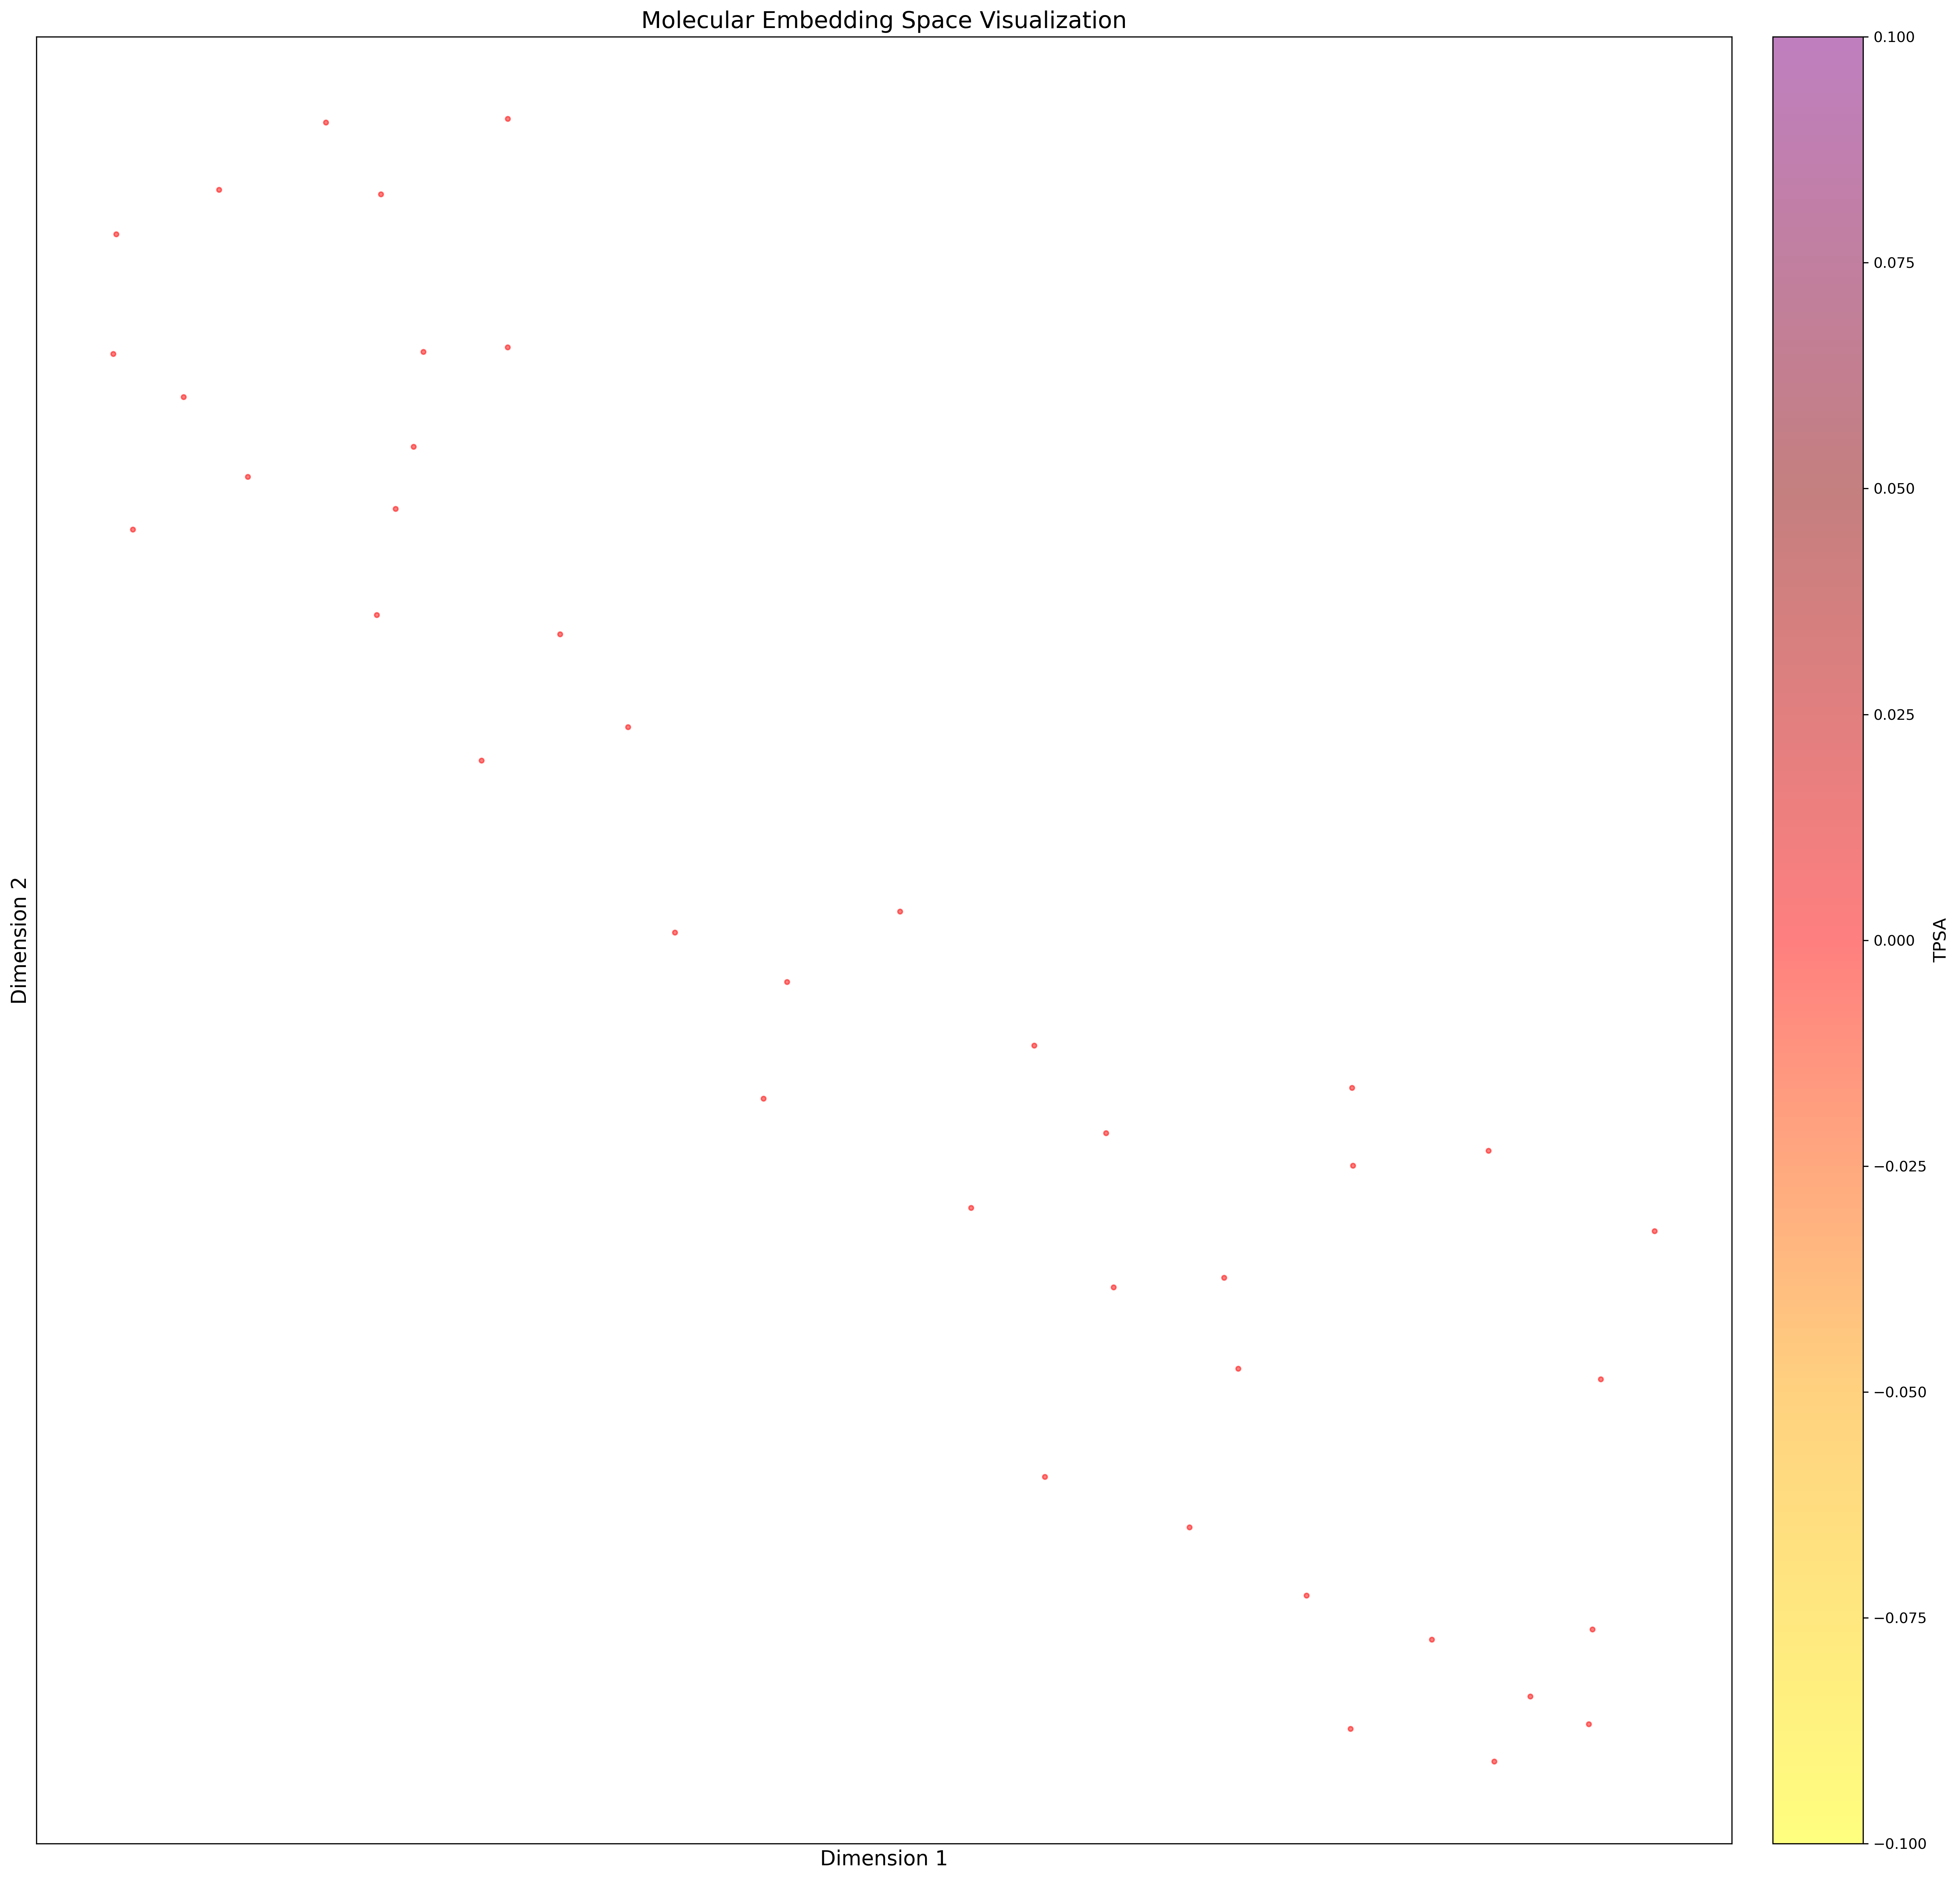

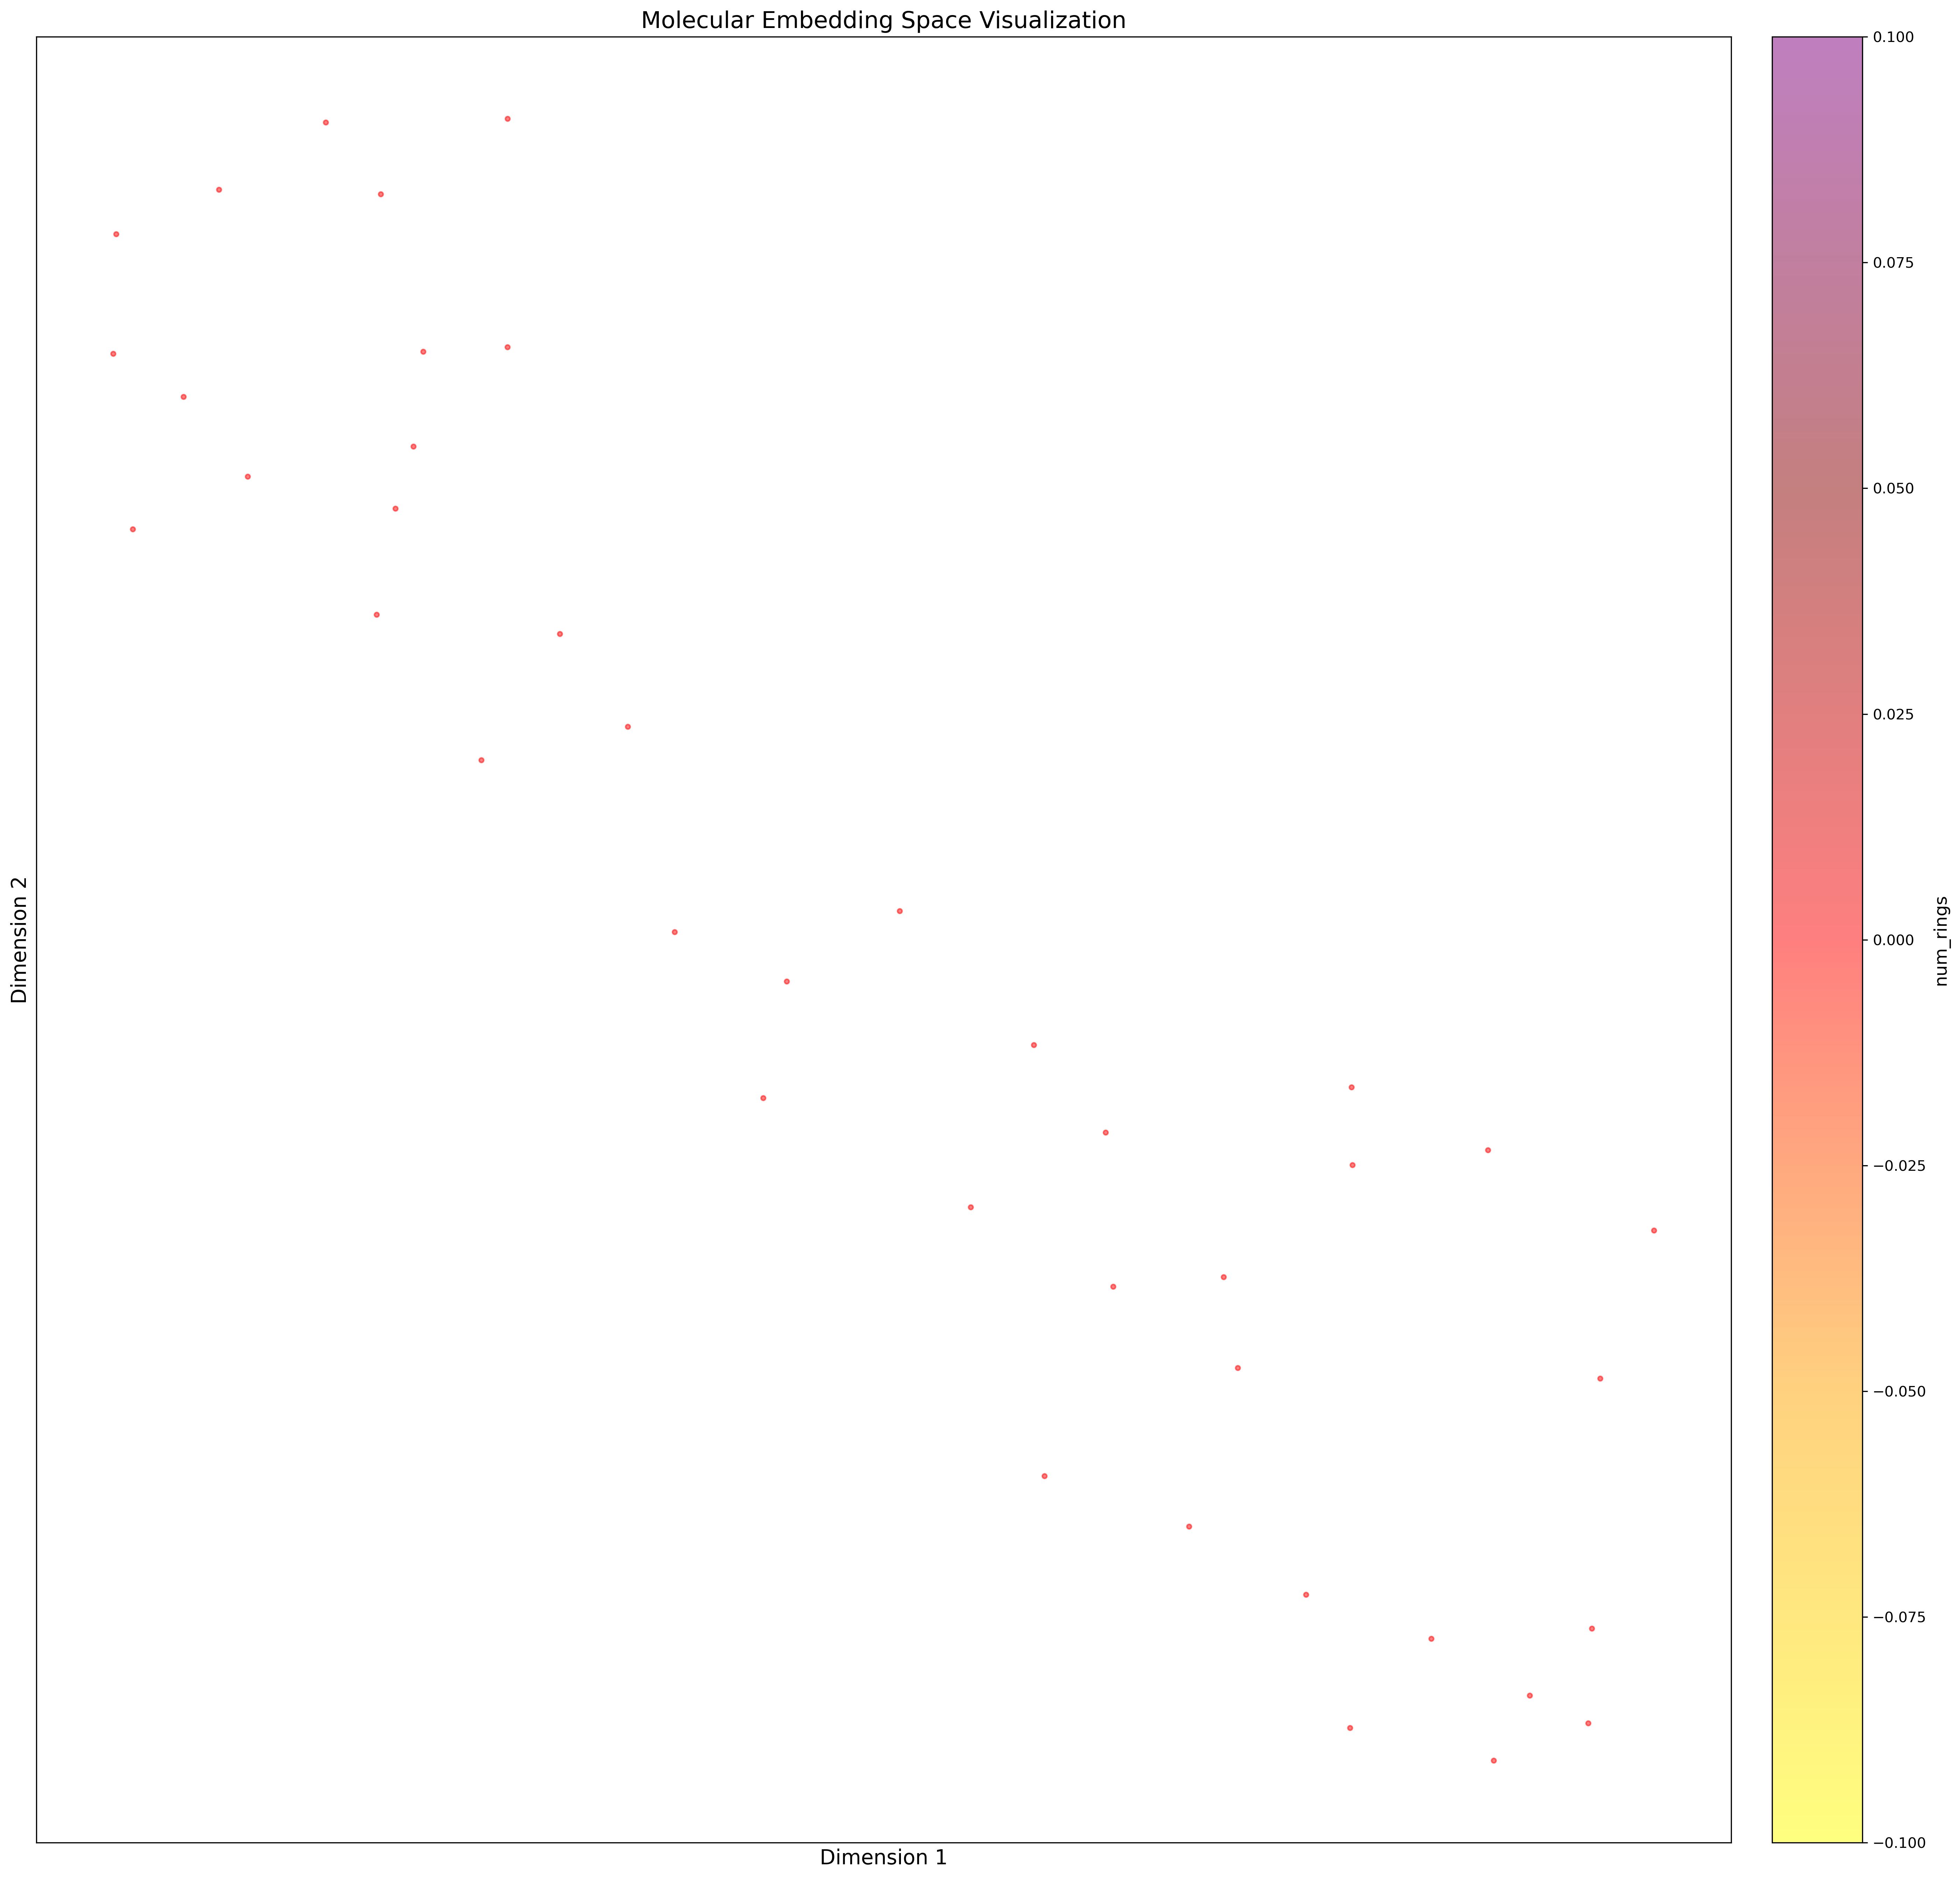

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import io
from PIL import Image
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import os
from typing import List, Dict, Tuple, Optional, Union
import torch
from torch_geometric.data import Data
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


def load_embeddings(filepath):
    """Load embeddings and molecule data from file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    return embeddings, molecule_data


def reduce_dimensions(embeddings, method='tsne', n_components=2, **kwargs):
    """Reduce dimensionality of embeddings for visualization"""
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings


def rebuild_molecules_from_graph_data(molecule_data_list):
    """Reconstruct RDKit molecules from graph data"""
    molecules = []
    
    # Maps for atom and bond features
    atom_list = list(range(1, 119))
    chirality_list = [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ]
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    for mol_data in molecule_data_list:
        try:
            # Create empty editable molecule
            mol = Chem.RWMol()
            
            # Add atoms based on x_cat data
            x_cat = mol_data.get('x_cat')
            if x_cat is None:
                molecules.append(None)
                continue
                
            for atom_features in x_cat:
                atomic_num = atom_list[atom_features[0]]
                atom = Chem.Atom(atomic_num)
                atom.SetChiralTag(chirality_list[atom_features[1]])
                mol.AddAtom(atom)
            
            # Add bonds based on edge_index and edge_attr
            edge_index = mol_data.get('edge_index')
            edge_attr = mol_data.get('edge_attr')
            
            if edge_index is None or edge_attr is None:
                molecules.append(Chem.Mol(mol))
                continue
                
            # Process only in one direction (undirected edges appear twice)
            processed_edges = set()
            
            for i in range(len(edge_index[0])):
                start, end = edge_index[0][i], edge_index[1][i]
                if (start, end) in processed_edges or (end, start) in processed_edges:
                    continue
                    
                # Add the bond
                bond_type = bond_list[int(edge_attr[i][0])]
                mol.AddBond(start, end, bond_type)
                processed_edges.add((start, end))
            
            # Convert to molecule and add hydrogen
            try:
                final_mol = Chem.Mol(mol)
                final_mol = Chem.AddHs(final_mol)
                
                # Sanitize and compute 2D coordinates for visualization
                Chem.SanitizeMol(final_mol)
                AllChem.Compute2DCoords(final_mol)
                
                molecules.append(final_mol)
            except Exception as e:
                print(f"Error finalizing molecule: {e}")
                molecules.append(None)
                
        except Exception as e:
            print(f"Error rebuilding molecule: {e}")
            molecules.append(None)
    
    return molecules


def calculate_molecular_properties(molecules):
    """Calculate various properties for the molecules"""
    properties = defaultdict(list)
    
    for mol in molecules:
        if mol is None:
            # Default values for missing molecules
            properties['mw'].append(0)
            properties['logp'].append(0)
            properties['tpsa'].append(0)
            properties['num_rings'].append(0)
            properties['num_hba'].append(0)
            properties['num_hbd'].append(0)
            properties['num_rotatable_bonds'].append(0)
            continue
            
        try:
            # Calculate basic properties
            properties['mw'].append(Descriptors.MolWt(mol))
            properties['logp'].append(Descriptors.MolLogP(mol))
            properties['tpsa'].append(Descriptors.TPSA(mol))
            properties['num_rings'].append(Descriptors.RingCount(mol))
            properties['num_hba'].append(Descriptors.NumHAcceptors(mol))
            properties['num_hbd'].append(Descriptors.NumHDonors(mol))
            properties['num_rotatable_bonds'].append(Descriptors.NumRotatableBonds(mol))
        except Exception as e:
            print(f"Error calculating properties: {e}")
            # Default values on error
            properties['mw'].append(0)
            properties['logp'].append(0)
            properties['tpsa'].append(0)
            properties['num_rings'].append(0)
            properties['num_hba'].append(0)
            properties['num_hbd'].append(0)
            properties['num_rotatable_bonds'].append(0)
    
    # Convert to numpy arrays
    for key in properties:
        properties[key] = np.array(properties[key])
    
    return properties


def identify_functional_groups(molecules):
    """Identify functional groups in molecules using RDKit's functional group filtering"""
    from rdkit.Chem import MolFromSmarts
    
    # Define common functional groups with SMARTS patterns
    functional_groups = {
        'carboxylic_acid': '[CX3](=O)[OX2H1]',
        'ester': '[CX3](=O)[OX2][CX4]',
        'amide': '[NX3][CX3](=[OX1])',
        'amine': '[NX3;H2,H1,H0;!$(NC=O)]',
        'hydroxyl': '[OX2H]',
        'carbonyl': '[CX3]=[OX1]',
        'alkene': '[CX3]=[CX3]',
        'alkyne': '[CX2]#[CX2]',
        'aromatic': 'c1ccccc1',
        'heterocycle': '[a;!c]',
        'phenol': '[OX2H][cX3]:[cX3]',
        'nitro': '[NX3](=O)=O',
        'nitrile': '[NX1]#[CX2]',
        'halogen': '[F,Cl,Br,I]',
        'sulfide': '[#16X2][#6]',
        'sulfonyl': '[#16X4](=[OX1])(=[OX1])',
        'phosphate': '[P,p][OX2][CX4]'
    }
    
    # Compile patterns
    patterns = {name: MolFromSmarts(smarts) for name, smarts in functional_groups.items()}
    
    # Initialize results
    group_counts = defaultdict(list)
    
    for mol in molecules:
        if mol is None:
            # Add zeros for all groups if molecule is None
            for group in functional_groups:
                group_counts[group].append(0)
            continue
        
        # Count occurrences of each functional group
        for group_name, pattern in patterns.items():
            if pattern is not None:
                matches = mol.GetSubstructMatches(pattern)
                group_counts[group_name].append(len(matches))
            else:
                group_counts[group_name].append(0)
    
    # Convert to numpy arrays
    for key in group_counts:
        group_counts[key] = np.array(group_counts[key])
    
    return group_counts


def mol_to_image(mol, size=(200, 200), highlight_atoms=None, highlight_color=(0.9, 0.6, 0.6), 
                kekulize=True, legend=None):
    """Convert RDKit molecule to matplotlib-compatible image"""
    if mol is None:
        return None
        
    try:
        # Create a drawing object and set up parameters
        drawer = rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
        drawer.drawOptions().addStereoAnnotation = True
        drawer.drawOptions().additionalAtomLabelPadding = 0.3
        
        # Highlight atoms if specified
        highlight_atoms = highlight_atoms or []
        highlight_bonds = []
        
        # Kekulize if requested
        mol_copy = Chem.Mol(mol)
        if kekulize:
            try:
                Chem.Kekulize(mol_copy)
            except:
                pass
        
        # Draw the molecule
        if legend:
            drawer.DrawMolecule(mol_copy, legend=legend, highlightAtoms=highlight_atoms, 
                              highlightAtomColors={i: highlight_color for i in highlight_atoms},
                              highlightBonds=highlight_bonds)
        else:
            drawer.DrawMolecule(mol_copy, highlightAtoms=highlight_atoms, 
                              highlightAtomColors={i: highlight_color for i in highlight_atoms},
                              highlightBonds=highlight_bonds)
                              
        drawer.FinishDrawing()
        
        # Get PNG data
        png_data = drawer.GetDrawingText()
        
        # Convert to image
        image = Image.open(io.BytesIO(png_data))
        return image
    except Exception as e:
        print(f"Error rendering molecule: {e}")
        return None


def find_cluster_representatives(embeddings_2d, clusters, molecules, n_per_cluster=2):
    """Find representative molecules for each cluster"""
    # Get cluster centers
    unique_clusters = np.unique(clusters)
    representatives = {}
    
    for cluster_id in unique_clusters:
        # Get points in this cluster
        cluster_mask = clusters == cluster_id
        cluster_points = embeddings_2d[cluster_mask]
        cluster_indices = np.where(cluster_mask)[0]
        
        if len(cluster_points) == 0:
            continue
            
        # Find centroid
        centroid = np.mean(cluster_points, axis=0)
        
        # Find closest points to centroid
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        closest_indices = np.argsort(distances)[:n_per_cluster]
        
        # Map back to original indices and filter for valid molecules
        representative_indices = [cluster_indices[i] for i in closest_indices 
                                if molecules[cluster_indices[i]] is not None]
        
        if representative_indices:
            representatives[cluster_id] = representative_indices
    
    return representatives


def create_advanced_visualization(embeddings_2d, molecules, properties, func_groups,
                                clusters, cluster_representatives,
                                figsize=(18, 16), dpi=300, save_path=None,
                                property_to_plot='mw'):
    """Create advanced visualization with molecule structures and property coloring"""
    # Create figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    # Set up grid for the main plot and the colorbar
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    
    # Create custom colormap
    cmap = LinearSegmentedColormap.from_list('molecular_weight', [
        '#FFFF00',  # light yellow
        '#FFA500',  # orange
        '#FF0000',  # red
        '#8B0000',  # dark red
        '#800080',  # purple
    ])
    
    # Plot the property-colored scatter points
    property_values = properties[property_to_plot]
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=property_values, cmap=cmap, alpha=0.5, s=10)
    
    # Add colorbar with proper scaling
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    
    if property_to_plot == 'mw':
        cbar.set_label('Molecular weight', fontsize=12)
    elif property_to_plot == 'logp':
        cbar.set_label('LogP', fontsize=12)
    elif property_to_plot == 'tpsa':
        cbar.set_label('TPSA', fontsize=12)
    else:
        cbar.set_label(property_to_plot, fontsize=12)
    
    # Create a bounding box for the colorbar
    pos = cbar.ax.get_position()
    cbar.ax.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height * 0.9])
    
    # Plot representative molecules for each cluster
    for cluster_id, representative_indices in cluster_representatives.items():
        for idx in representative_indices:
            if molecules[idx] is not None:
                # Determine molecule box position
                x, y = embeddings_2d[idx]
                
                # Create molecule image
                mol = molecules[idx]
                img = mol_to_image(mol, size=(300, 300))
                
                if img is not None:
                    # Create box with molecule
                    img_array = np.array(img)
                    imagebox = OffsetImage(img_array, zoom=0.35)
                    
                    # Create annotation box around molecule
                    ab = AnnotationBbox(
                        imagebox, 
                        (x, y),
                        xycoords='data',
                        boxcoords='data',
                        pad=0.2,
                        frameon=True,
                        bboxprops=dict(edgecolor='black', linewidth=1.5, alpha=0.8)
                    )
                    
                    ax.add_artist(ab)
    
    # Add title and labels
    ax.set_title('Molecular Embedding Space Visualization', fontsize=16)
    ax.set_xlabel('Dimension 1', fontsize=14)
    ax.set_ylabel('Dimension 2', fontsize=14)
    
    # Remove ticks for cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add grid to background
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    return fig


def cluster_embeddings(embeddings_2d, n_clusters=8):
    """Cluster the embeddings using KMeans"""
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings_2d)
    
    return clusters


def main():
    # Create output directory
    os.makedirs('./visualizations', exist_ok=True)
    
    # Load the embeddings
    # Update with your actual file path
    embeddings_path = './embeddings/final_embeddings_molecules_20250308_221455.pkl'
    print(f"Loading embeddings from: {embeddings_path}")
    embeddings, molecule_data = load_embeddings(embeddings_path)
    
    print(f"Loaded {len(embeddings)} embeddings")
    
    # Reduce dimensions using UMAP
    print("Reducing dimensionality with UMAP...")
    embeddings_2d = reduce_dimensions(
        embeddings, 
        method='umap', 
        n_neighbors=15, 
        min_dist=0.1, 
        metric='cosine'
    )
    
    # Rebuild molecules from graph data
    print("Rebuilding molecules from graph data...")
    molecules = rebuild_molecules_from_graph_data(molecule_data)
    print(f"Successfully rebuilt {sum(1 for m in molecules if m is not None)} molecules")
    
    # Calculate properties for coloring
    print("Calculating molecular properties...")
    properties = calculate_molecular_properties(molecules)
    
    # Identify functional groups
    print("Identifying functional groups...")
    func_groups = identify_functional_groups(molecules)
    
    # Cluster the data
    print("Clustering embeddings...")
    n_clusters = 10  # Adjust based on your data
    clusters = cluster_embeddings(embeddings_2d, n_clusters=n_clusters)
    
    # Find representative molecules for each cluster
    print("Finding cluster representatives...")
    cluster_representatives = find_cluster_representatives(
        embeddings_2d, 
        clusters, 
        molecules, 
        n_per_cluster=3
    )
    
    # Create visualization
    print("Creating advanced visualization...")
    fig = create_advanced_visualization(
        embeddings_2d,
        molecules,
        properties,
        func_groups,
        clusters,
        cluster_representatives,
        figsize=(20, 18),
        dpi=300,
        save_path='./visualizations/advanced_molecular_embedding.png',
        property_to_plot='mw'  # Options: 'mw', 'logp', 'tpsa', etc.
    )
    
    # Create additional visualizations with different properties
    print("Creating additional visualizations with different properties...")
    for prop in ['logp', 'tpsa', 'num_rings']:
        print(f"Visualizing by {prop}...")
        fig = create_advanced_visualization(
            embeddings_2d,
            molecules,
            properties,
            func_groups,
            clusters,
            cluster_representatives,
            figsize=(20, 18),
            dpi=300,
            save_path=f'./visualizations/molecular_embedding_{prop}.png',
            property_to_plot=prop
        )
    
    print("Visualization complete!")


if __name__ == "__main__":
    main()